In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
def calculate_error_bounds(ds):
    
    pem = ds.mean(dim = 'ensemble_member')
    psd = ds.std(dim = 'ensemble_member', ddof=1)
    
    upperbound = pem + psd
    upperbound['aice'] = upperbound.aice.where(upperbound.aice < 1, 1)
    lowerbound = pem - psd 
    
    return upperbound, lowerbound, pem

## Aggregate Observations 

In [3]:
file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/aggregate_observations.nc"
ds_test = xr.open_dataset(file)

file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_SHEBA/netcdfs/aggregate_observations.nc"
ds_SHEBA = xr.open_dataset(file)

In [4]:
x = ds_test.time[0:1092:3]

In [5]:
free_ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE/free_ens.nc')
fup, flw, fem = calculate_error_bounds(free_ds)

### Temporal Line Plots 

/glade/scratch/mollyw/ipykernel_103404/2490003927.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=12)
/glade/scratch/mollyw/ipykernel_103404/2490003927.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=12)


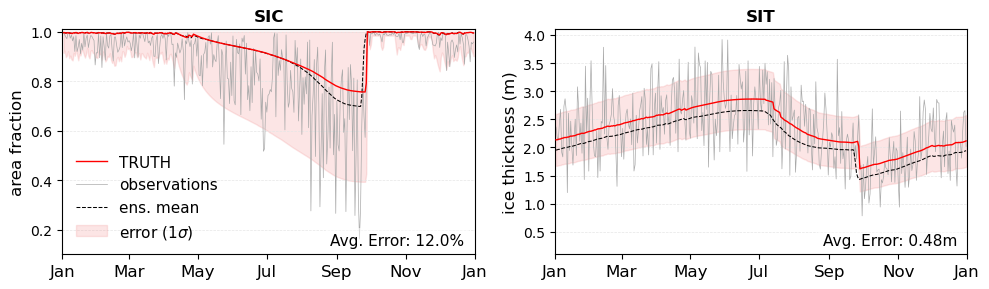

In [6]:
fig, ax = plt.subplots(1, len(list(np.unique(ds_test.obs_type)))-1, figsize=(10, 3))

obs_names = ["SIC", "SIT"]
units = ["%", "m"]
ens_vars = ['aice','hi','vsno']

count = 0
for ob_ind in list(np.unique(ds_test.obs_type)[1:]):
    ens_var=ens_vars[count]
    type1 = ds_test.observations.where(ds_test.obs_type == ob_ind, drop=True)
    # type2 = ds_SHEBA.oxbservations.where(ds_SHEBA.obs_type == ob_ind, drop=True).isel(ObsIndex = slice(0,364))
    
    obs1 = type1.sel({"copy": 1})
    truth = type1.sel({"copy": 2})
    error1 = type1.sel({"copy": 3})
    
    # obs2 = type2.sel({"copy": 1})
    # error2 = type2.sel({"copy": 3})
    
    ax[count].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    ax[count].plot(x, truth, label="TRUTH", color="red", lw=1, zorder = 3)
    ax[count].plot(x, obs1, label="observations", color="darkgrey", lw=0.5, zorder = 2)
    ax[count].plot(x, fem[ens_var], label = 'ens. mean', color = 'black', lw = 0.75, linestyle='dashed')
    # ax[count].plot(x, obs2, label="Observations- low error", color="grey", lw=0.5)
    
    if ob_ind == 27:
        
        upper1 = truth + np.sqrt(error1)
        upper1 = upper1.where(upper1 < 1, 1)
        
        # upper2 = truth + np.sqrt(error2)
        # upper2 = upper2.where(upper2 < 1, 1)
        
        ax[count].fill_between(
            x=x,
            y1=truth - np.sqrt(error1) - (truth + np.sqrt(error1) - 1),
            y2=upper1, #np.ones(len(truth)),
            zorder = 1,
            color="lightcoral",
            alpha=0.2,
            label="error (1$\sigma$)",
        )
        
    else:
        ax[count].fill_between(
            x=x,
            y1=truth - np.sqrt(error1),
            y2=truth + np.sqrt(error1),
            zorder = 1,
            color="lightcoral",
            alpha=0.2,
            label="error (1$\sigma$)",
        )
        
    ax[count].set_title(obs_names[count], fontweight="bold", fontsize=12)
    # ax[count].set_xlabel("Day of Year")
    ax[count].set_xlim([365*41 + 10, 365*42+10])
    # display the mean error value for each observation type in the lower right corner
    if count == 0:
        rhs = 0.65
        fac = 100
        ax[count].set_ylim([0.1, 1.01])
    else:
        rhs = 0.65
        fac = 1
        ax[count].set_ylim([0.1, 4.1])

                       
    ax[count].text(
        rhs,
        0.04,
        "Avg. Error: "
        + str(np.round(np.mean(np.sqrt(error1)).values, 2) * fac)
        + units[count],
        # + ', ' + str(np.round(np.mean(np.sqrt(error2)).values, 2) * fac)
        # + units[count],
        transform=ax[count].transAxes,
        fontsize=11,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor = 'white',alpha=0.5),
    )
    
    ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=12)

    count += 1
    
ax[0].set_ylabel("area fraction", fontsize=12)
ax[1].set_ylabel("ice thickness (m)", fontsize=12)
ax[0].legend(frameon=False, loc="lower left", fontsize=11)

plt.tight_layout()
plt.savefig('figures/AGGREG_observations.png', dpi=300, bbox_inches='tight')

### Histograms

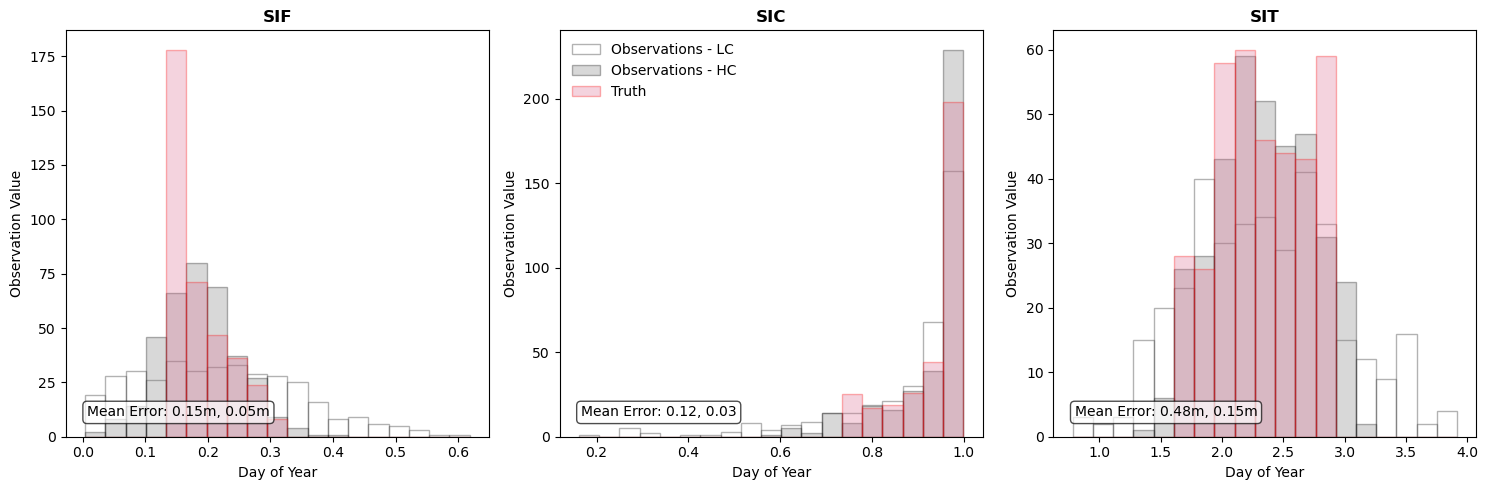

In [70]:
fig, ax = plt.subplots(1, len(list(np.unique(ds_test.obs_type))), figsize=(15, 5))

obs_names = ["SIF", "SIC", "SIT"]
units = ["m", "", "m"]

count = 0
for ob_ind in list(np.unique(ds_test.obs_type)):
    type1 = ds_test.observations.where(ds_test.obs_type == ob_ind, drop=True)
    type2 = ds_SHEBA.observations.where(ds_SHEBA.obs_type == ob_ind, drop=True).isel(ObsIndex = slice(0,364))

    obs1 = type1.sel({"copy": 1})
    truth = type1.sel({"copy": 2})
    error1 = type1.sel({"copy": 3})
    
    obs2 = type2.sel({"copy": 1})
    error2 = type2.sel({"copy": 3})

    binwidth = np.linspace(min(obs1), max(obs1), 20)

    ax[count].hist(
        obs1,
        label="Observations - LC",
        color="white",
        edgecolor="black",
        alpha=0.3,
        bins=binwidth,
    )
    
    ax[count].hist(
        obs2,
        label="Observations - HC",
        color="grey",
        edgecolor="black",
        alpha=0.3,
        bins=binwidth,
    )
    
    ax[count].hist(
        truth, label="Truth", color="palevioletred", edgecolor="red", alpha=0.3, bins=binwidth
    )

    ax[count].set_title(obs_names[count], fontweight="bold")
    ax[count].set_xlabel("Day of Year")
    ax[count].set_ylabel("Observation Value")

    # display the mean error value for each observation type in the lower right corner
    ax[count].text(
        0.05,
        0.05,
        "Mean Error: "
        + str(np.round(np.mean(np.sqrt(error1)).values, 2))
        + units[count]
        + ', ' + str(np.round(np.mean(np.sqrt(error2)).values, 2))
        + units[count],
        transform=ax[count].transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
    )

    count += 1

ax[count - 2].legend(frameon=False, loc="upper left")

plt.tight_layout()

## ITD Observations

In [7]:
file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/itd_observations.nc"
ds = xr.open_dataset(file)

### Temporal Line Plots

/glade/scratch/mollyw/ipykernel_103404/2796598946.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=11, rotation = 50)
/glade/scratch/mollyw/ipykernel_103404/2796598946.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=11, rotation = 50)
/glade/scratch/mollyw/ipykernel_103404/2796598946.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=11, rotation = 50)
/glade/scratch/mollyw/ipykernel_103404/2796598946.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=11, rotation = 50)
/glade/scratch/mollyw/ipykernel_103404/2796598946.py:65: UserWarning

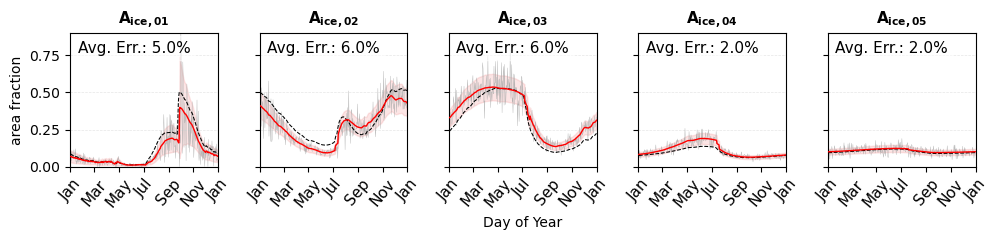

In [8]:
obs_types = ["AICE01", "AICE02", "AICE03", "AICE04", "AICE05"]
obs_names = ["cat 1 area", "cat 2 area", "cat 3 area", "cat 4 area", "cat 5 area"]
units = ["%", "%", "%", "%", "%"]

fig, ax = plt.subplots(1, len(obs_types), figsize=(10, 2.5))

count = 0
for ob in obs_types:
    ob_ind = (
        list.index(
            list(ds.ObsTypesMetaData.values),
            bytes("SAT_SEAICE_" + ob + "               ", "utf-8"),
        )
        + 1
    )

    type = ds.observations.where(ds.obs_type == ob_ind, drop=True)

    obs = type.sel({"copy": 1})
    truth = type.sel({"copy": 2})
    error = type.sel({"copy": 3})
    
    ax[count].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    ax[count].plot(x, truth, label="TRUTH", color="red", lw=1, zorder = 3)
    ax[count].plot(x, obs, label="obs.", color="darkgrey", lw=0.25, zorder = 2)
    ax[count].plot(x, fem.aicen.isel({'ncat':count}), label = 'ens. mean', color = 'black', lw = 0.75, linestyle='dashed')

    if ob_ind == 27:
        ax[count].fill_between(
            x=x,
            y1=truth - np.sqrt(error),
            y2=np.ones(len(truth)),
            color="lightcoral",
            zorder = 1,
            alpha=0.2,
            label="error (1$\sigma$)",
        )
    else:
        ax[count].fill_between(
            x=x,
            y1=truth - np.sqrt(error),
            y2=truth + np.sqrt(error),
            color="lightcoral",
            zorder = 1,
            alpha=0.2,
            label="error (1$\sigma$)",
        )
    ax[count].set_ylim([0,0.9])
    ax[count].set_xlim([365*41 + 10, 365*42+10])
    ax[count].set_title(r"$\mathbf{A_{ice,0"+str(count+1)+"}}$", fontweight="bold", fontsize=11)
    # display the mean error value for each observation type in the lower right corner
    ax[count].text(
        0.05,
        0.85,
        "Avg. Err.: "
        + str(np.round(np.mean(np.sqrt(error)).values, 2) * 100)
        + units[count],
        transform=ax[count].transAxes,
        fontsize=11,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor='white', alpha=0.5),
    )
    if count !=0:
        ax[count].set_yticklabels('')
    
    ax[count].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=11, rotation = 50)
    count += 1

ax[2].set_xlabel("Day of Year")
ax[0].set_ylabel("area fraction")

# ax[4].legend(frameon=False, loc="upper left", fontsize = 8)

plt.tight_layout()
plt.savefig('figures/ITD_observations.png', dpi=300, bbox_inches='tight')

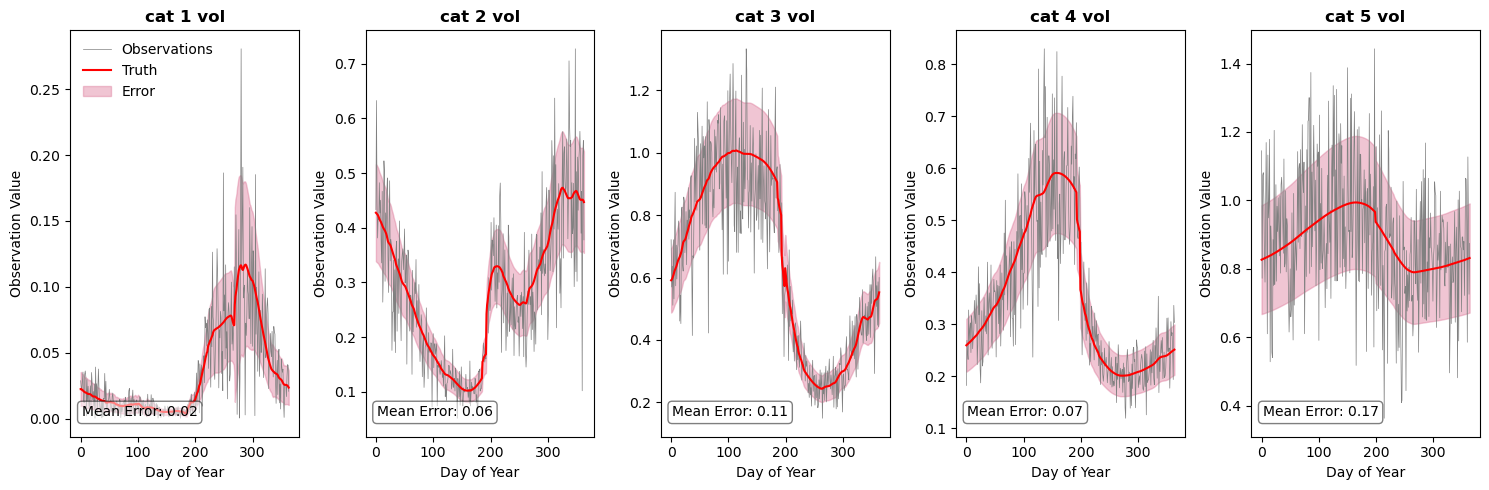

In [51]:
obs_types = ["VICE01", "VICE02", "VICE03", "VICE04", "VICE05"]
obs_names = ["cat 1 vol", "cat 2 vol", "cat 3 vol", "cat 4 vol", "cat 5 vol"]
units = ["", "", "", "", ""]

fig, ax = plt.subplots(1, len(obs_types), figsize=(15, 5))

count = 0
for ob in obs_types:
    ob_ind = (
        list.index(
            list(ds.ObsTypesMetaData.values),
            bytes("SAT_SEAICE_" + ob + "               ", "utf-8"),
        )
        + 1
    )

    type = ds.observations.where(ds.obs_type == ob_ind, drop=True)

    obs = type.sel({"copy": 1})
    truth = type.sel({"copy": 2})
    error = type.sel({"copy": 3})

    ax[count].plot(obs, label="Observations", color="grey", lw=0.5)
    ax[count].plot(truth, label="Truth", color="red", lw=1.5)
    if ob_ind == 27:
        ax[count].fill_between(
            x=np.arange(0, 364),
            y1=truth - np.sqrt(error),
            y2=np.ones(len(truth)),
            color="palevioletred",
            alpha=0.4,
            label="Error",
        )
    else:
        ax[count].fill_between(
            x=np.arange(0, 364),
            y1=truth - np.sqrt(error),
            y2=truth + np.sqrt(error),
            color="palevioletred",
            alpha=0.4,
            label="Error",
        )

    ax[count].set_title(obs_names[count], fontweight="bold")
    ax[count].set_xlabel("Day of Year")
    ax[count].set_ylabel("Observation Value")

    # display the mean error value for each observation type in the lower right corner
    ax[count].text(
        0.05,
        0.05,
        "Mean Error: "
        + str(np.round(np.mean(np.sqrt(error)).values, 2))
        + units[count],
        transform=ax[count].transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    count += 1

ax[count - 5].legend(frameon=False, loc="upper left")

plt.tight_layout()

### Histograms

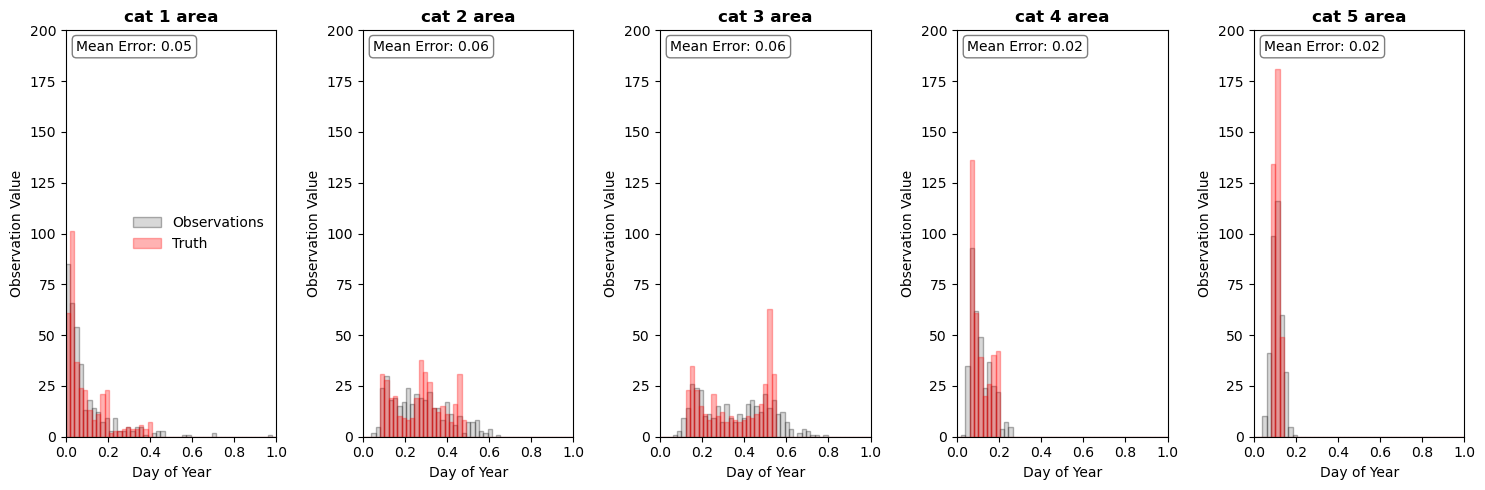

In [36]:
obs_types = ["AICE01", "AICE02", "AICE03", "AICE04", "AICE05"]
obs_names = ["cat 1 area", "cat 2 area", "cat 3 area", "cat 4 area", "cat 5 area"]
units = ["", "", "", "", ""]

fig, ax = plt.subplots(1, len(obs_types), figsize=(15, 5))
binwidth = np.linspace(0, 1, 50)

count = 0
for ob in obs_types:
    ob_ind = (
        list.index(
            list(ds.ObsTypesMetaData.values),
            bytes("SAT_SEAICE_" + ob + "               ", "utf-8"),
        )
        + 1
    )

    type = ds.observations.where(ds.obs_type == ob_ind, drop=True)

    obs = type.sel({"copy": 1})
    truth = type.sel({"copy": 2})
    error = type.sel({"copy": 3})

    ax[count].hist(
        obs,
        label="Observations",
        color="grey",
        edgecolor="black",
        alpha=0.3,
        bins=binwidth,
    )
    ax[count].hist(
        truth, label="Truth", color="red", edgecolor="red", alpha=0.3, bins=binwidth
    )

    ax[count].set_title(obs_names[count], fontweight="bold")
    ax[count].set_xlabel("Day of Year")
    ax[count].set_ylabel("Observation Value")
    ax[count].set_xlim([0, 1])
    ax[count].set_ylim([0, 200])

    # display the mean error value for each observation type in the lower right corner
    ax[count].text(
        0.05,
        0.95,
        "Mean Error: "
        + str(np.round(np.mean(np.sqrt(error)).values, 2))
        + units[count],
        transform=ax[count].transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    count += 1

ax[count - 5].legend(frameon=False, loc="center right")

plt.tight_layout()

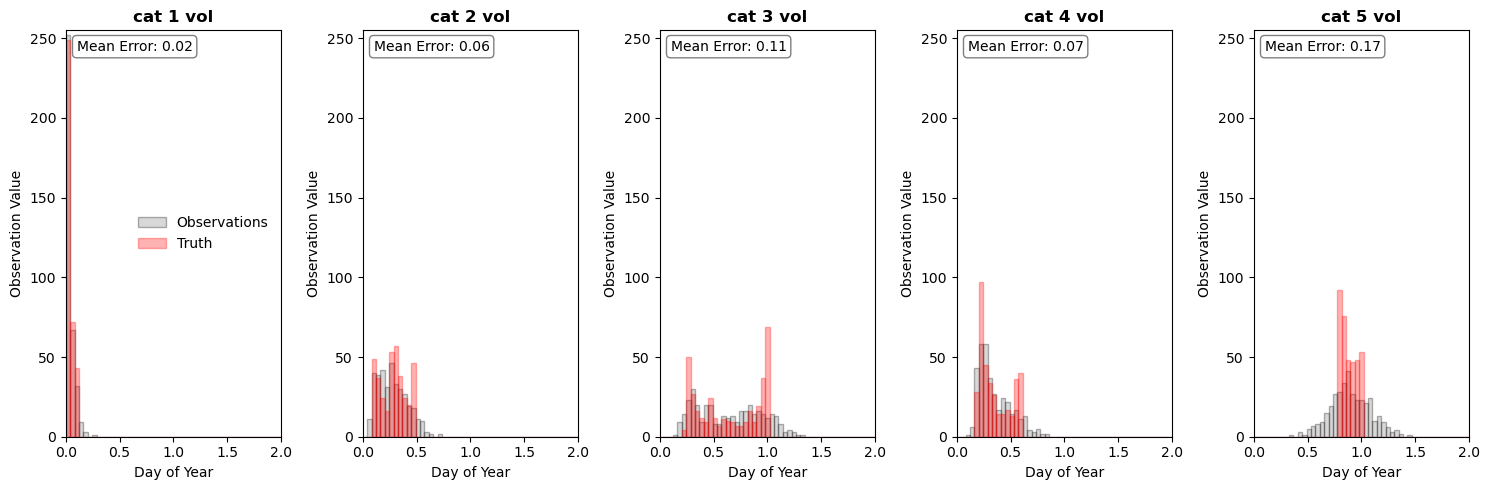

In [41]:
obs_types = ["VICE01", "VICE02", "VICE03", "VICE04", "VICE05"]
obs_names = ["cat 1 vol", "cat 2 vol", "cat 3 vol", "cat 4 vol", "cat 5 vol"]
units = ["", "", "", "", ""]

fig, ax = plt.subplots(1, len(obs_types), figsize=(15, 5))
binwidth = np.linspace(0, 2, 50)
count = 0
for ob in obs_types:
    ob_ind = (
        list.index(
            list(ds.ObsTypesMetaData.values),
            bytes("SAT_SEAICE_" + ob + "               ", "utf-8"),
        )
        + 1
    )

    type = ds.observations.where(ds.obs_type == ob_ind, drop=True)

    obs = type.sel({"copy": 1})
    truth = type.sel({"copy": 2})
    error = type.sel({"copy": 3})

    ax[count].hist(
        obs,
        label="Observations",
        color="grey",
        edgecolor="black",
        alpha=0.3,
        bins=binwidth,
    )
    ax[count].hist(
        truth, label="Truth", color="red", edgecolor="red", alpha=0.3, bins=binwidth
    )

    ax[count].set_title(obs_names[count], fontweight="bold")
    ax[count].set_xlabel("Day of Year")
    ax[count].set_ylabel("Observation Value")
    ax[count].set_xlim([0, 2])
    ax[count].set_ylim([0, 255])

    # display the mean error value for each observation type in the lower right corner
    ax[count].text(
        0.05,
        0.95,
        "Mean Error: "
        + str(np.round(np.mean(np.sqrt(error)).values, 2))
        + units[count],
        transform=ax[count].transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    count += 1

ax[count - 5].legend(frameon=False, loc="center right")

plt.tight_layout()

In [4]:
error = ds.observations.sel({'copy':3})

In [5]:
error

<xarray.DataArray 'observations' (ObsIndex: 3640)>
[3640 values with dtype=float64]
Coordinates:
    copy      int32 3
  * ObsIndex  (ObsIndex) int32 1 2 3 4 5 6 7 ... 3635 3636 3637 3638 3639 3640
Attributes:
    long_name:    org observation, estimates, etc.
    explanation:  see CopyMetaData

In [6]:
obs_types = ["VICE01", "VICE02", "VICE03", "VICE04", "VICE05"]
obs_names = ["cat 1 vol", "cat 2 vol", "cat 3 vol", "cat 4 vol", "cat 5 vol"]
units = ["", "", "", "", ""]

ERRS = [] 
count = 0 
for ob in obs_types:
    ob_ind = (
        list.index(
            list(ds.ObsTypesMetaData.values),
            bytes("SAT_SEAICE_" + ob + "               ", "utf-8"),
        )
        + 1
    )

    type = ds.observations.where(ds.obs_type == ob_ind, drop=True)
    
    error = type.sel({"copy": 3})
    
    ERRS.append(error)

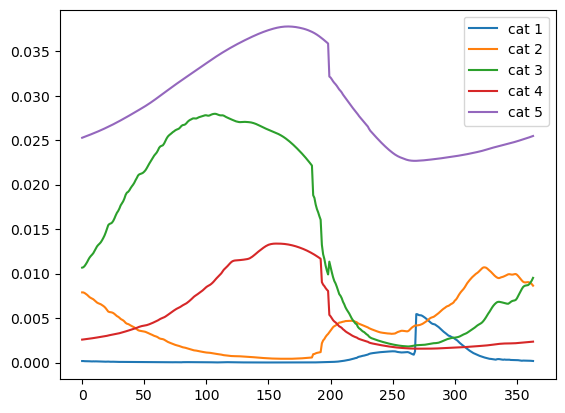

In [25]:
corrs = []
for i in range(0,len(ERRS)):
    for j in range(0, len(ERRS)):
        corrs.append(np.corrcoef(ERRS[i], ERRS[j])[0,1])
    plt.plot(ERRS[i], label = 'cat '+str(i+1))

plt.legend()

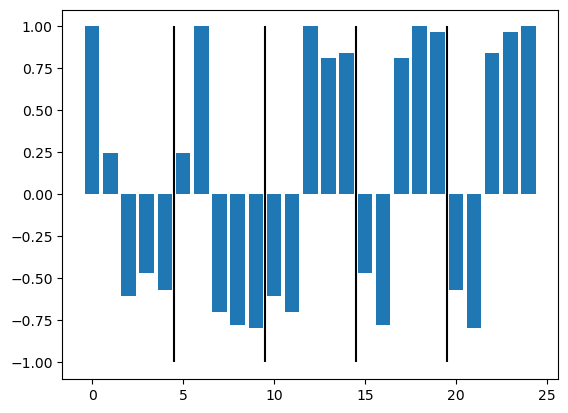

In [23]:
plt.bar(x = np.arange(0, len(corrs)), height = corrs)
plt.vlines(x = 4.5, ymin = -1, ymax = 1, color = 'k')
plt.vlines(x = 9.5, ymin = -1, ymax = 1, color = 'k')
plt.vlines(x = 14.5, ymin = -1, ymax = 1, color = 'k')
plt.vlines(x = 19.5, ymin = -1, ymax = 1, color = 'k')